<a href="https://colab.research.google.com/github/tsatir/Thinkful-Data_Science/blob/master/Model_preparataion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [0]:
#First, load the dataset.

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexpectancy = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [0]:
lifeexpectancy.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [0]:
def eda(dataframe):
    print('MISSING VALUES\n', dataframe.isnull().sum())
    print('\n DATA TYPES \n', dataframe.dtypes)
    print('\n DATA SHAPE \n', dataframe.shape)
    print('\n DATA DESCRIBE \n', dataframe.describe())
    for item in dataframe:
        print('\n UNIQUE VALUE TOTALS \n',item)
        print(dataframe[item].nunique())
        print(dataframe[item].value_counts())     
eda(lifeexpectancy)

MISSING VALUES
 Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

 DATA TYPES 
 Country                             object
Year                                 int64
Status      

All variables are continuous values except Status.



In [0]:
lifeexpectancy.Status.unique()

array(['Developing', 'Developed'], dtype=object)

# 1.Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

# **Missing Values**

Our dataset has 2038 rows and 22 columns. Thinking of 15 years and 193 countries data it is not a big dataset. So, every observation in our dataset carries some information and that information could be invaluable to our analysis. Instead of dropping missing values, I will fill them with interpolation. We don't have every countries every information for every year. That's why populating missing values using representative values from similar rows is suitable for our analysis. Our dataset is sorted by country and year. We can apply interpolation. 

In [0]:
missing_columns = list(lifeexpectancy.columns[lifeexpectancy.isnull().any()])
missing_columns

#country_list = list(lifeexpectancy.Country.unique())
#country_list

['Life expectancy ',
 'Adult Mortality',
 'Alcohol',
 'Hepatitis B',
 ' BMI ',
 'Polio',
 'Total expenditure',
 'Diphtheria ',
 'GDP',
 'Population',
 ' thinness  1-19 years',
 ' thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

In [0]:
#filling missing columns with interpolation method. 

for col in missing_columns:
    lifeexpectancy.loc[:, col] = lifeexpectancy.loc[:, col].interpolate()

In [0]:
#Yay! No more missing values!
lifeexpectancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2938 non-null float64
Adult Mortality                    2938 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2938 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2938 non-null float64
Measles                            2938 non-null int64
 BMI                               2938 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2938 non-null float64
Total expenditure                  2938 non-null float64
Diphtheria                         2938 non-null float64
 HIV/AIDS                          2938 non-null

# **Outliers**

We need to find the outliers first to understand how to deal with them.
There are couple of methods to detect them. I will use boxplot to visualize each column.

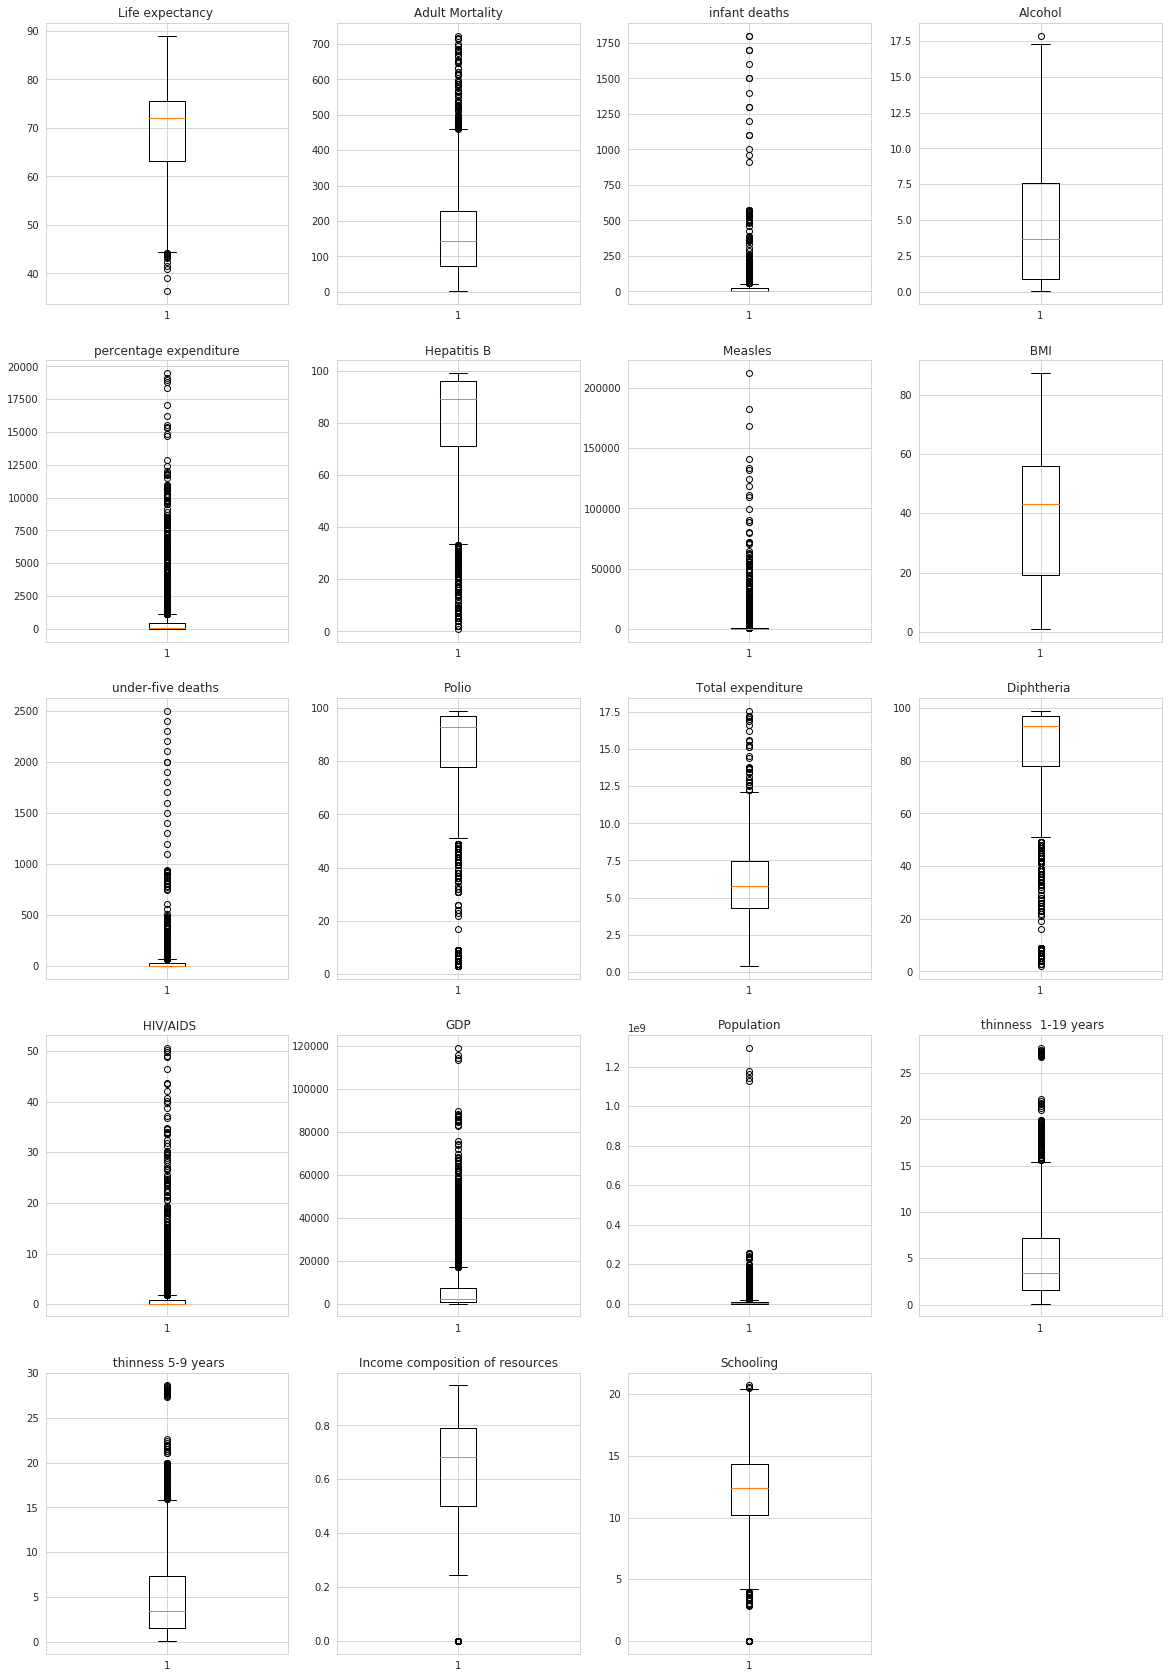

In [0]:
xx = lifeexpectancy.iloc[:,3:]
#xx.head

plt.figure(figsize=(20,30))

for col_names in list(xx.columns):
    
    plt.subplot(5,4,(list(xx.columns).index(col_names)+1))
    plt.boxplot(lifeexpectancy[col_names], whis=1.5)
    plt.title(col_names)
    
plt.show()

Boxplots represent that we need the transform some of the outliers. I will applly Tukey's method and see the number of outliers. Tukey's method is also known as IQR, uses the range between 1st and 3rd quartiles. It classifies outliers if the values are outside the threshold of 1.5 times the IQR.

In [0]:
# NumPy's percentile() method returns the 
# values of the given percentiles. In our case,
# we give 75 and 25 as parameters which corresponds 
# to the third and the first quartile.

for variable in list(xx.columns):
   q75, q25 = np.percentile(lifeexpectancy[variable], [75 ,25])
   iqr = q75 - q25

   min_val = q25 - (iqr*1.5)
   max_val = q75 + (iqr*1.5)
   print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                                             len((np.where((lifeexpectancy[variable] > max_val) | 
                                                                                           (lifeexpectancy[variable] < min_val))[0])),len((np.where((lifeexpectancy[variable] > max_val) | 
                                                                                           (lifeexpectancy[variable] < min_val))[0]))*100/2938))   

Number of outliers and percentage of it in Life expectancy  : 12 and 0.4084411164057182
Number of outliers and percentage of it in Adult Mortality : 82 and 2.791014295439074
Number of outliers and percentage of it in infant deaths : 315 and 10.721579305650103
Number of outliers and percentage of it in Alcohol : 1 and 0.03403675970047652
Number of outliers and percentage of it in percentage expenditure : 389 and 13.240299523485364
Number of outliers and percentage of it in Hepatitis B : 248 and 8.441116405718176
Number of outliers and percentage of it in Measles  : 542 and 18.44792375765827
Number of outliers and percentage of it in  BMI  : 0 and 0.0
Number of outliers and percentage of it in under-five deaths  : 394 and 13.410483321987746
Number of outliers and percentage of it in Polio : 282 and 9.598366235534376
Number of outliers and percentage of it in Total expenditure : 35 and 1.191286589516678
Number of outliers and percentage of it in Diphtheria  : 301 and 10.245064669843432
Nu

BMI variable is very strange. It is Average Body Mass Index of entire population. It has a high std and min value is 1 max value is 87. The values are misleading. Even though, Tukey's method says there is no outliers, I will deal with values close to 0 and values close to 80.

We found the outliers. We need to handle them to have more reliable analysis. 
I have 3 ways to handle to outliers.


1.   Dropping : I don't want to lose more datapoint. That's why I won't use this technique.
2.   Winsorization : It limits the values of the outliers. We can cap the outliers with the value of specified percentile. In that way, we can limit outliers affect on our analysis.
3.   Transforming variables



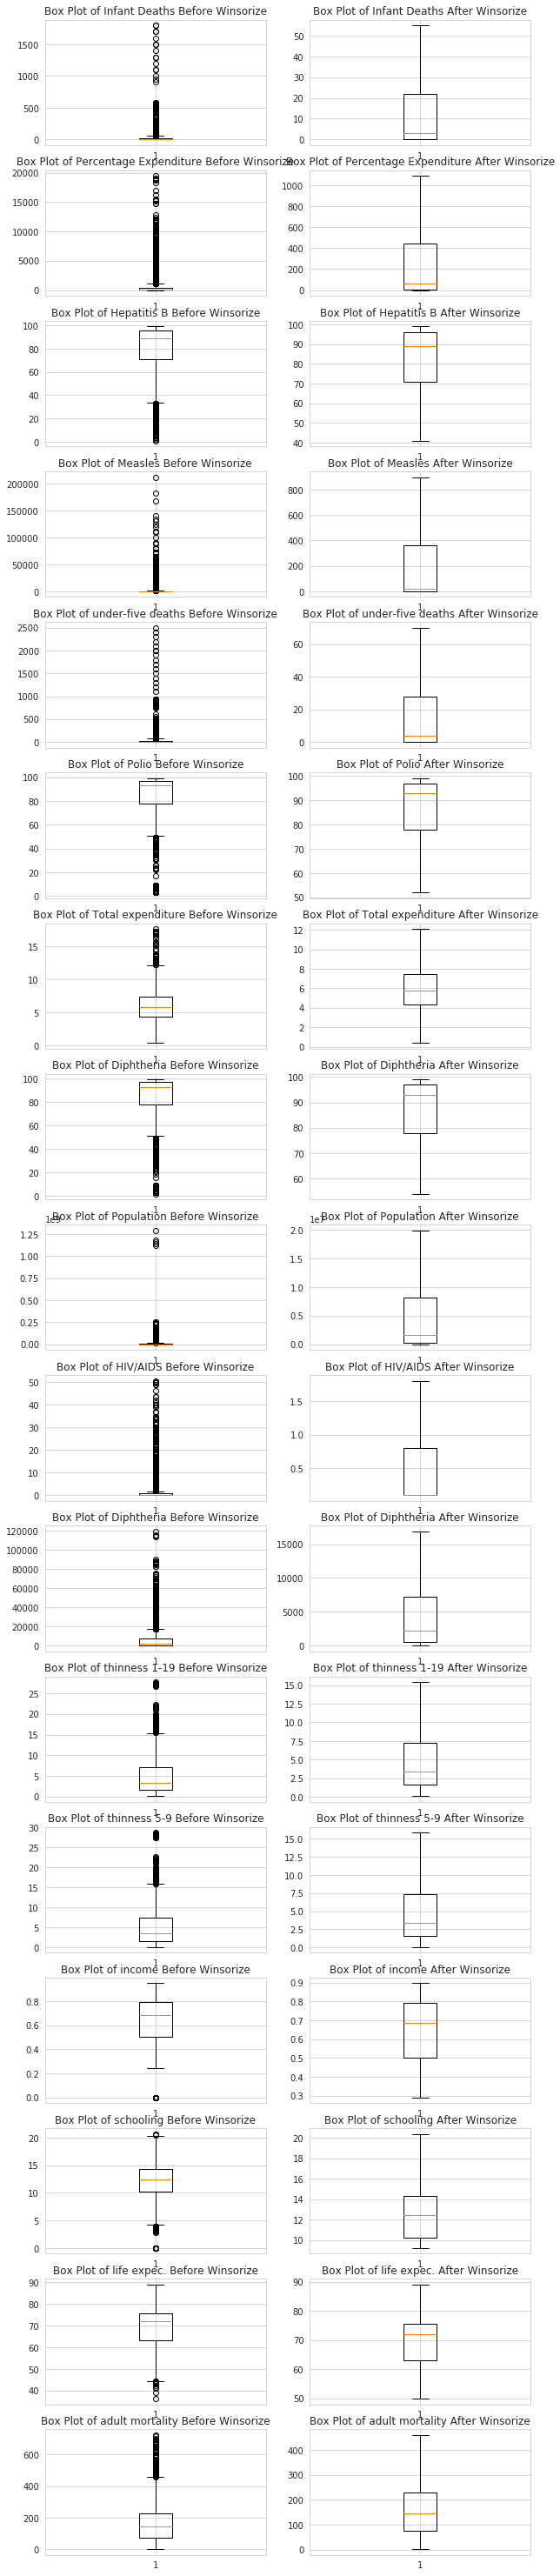

In [0]:
from scipy.stats.mstats import winsorize

#applying winsorize techniqu to cap the outliers and adding the new winsorized column to our dataset
#After adding the new winsorized column, I plot the before and after versions of columns with a boxplot

lifeexpectancy['winsorized_infant_deaths'] = winsorize(lifeexpectancy["infant deaths"], (0, 0.11))

plt.figure(figsize=(10,60))

plt.subplot(19,2,1)
plt.boxplot(lifeexpectancy["infant deaths"])
plt.title("Box Plot of Infant Deaths Before Winsorize")

plt.subplot(19,2,2)
plt.boxplot(lifeexpectancy['winsorized_infant_deaths'])
plt.title("Box Plot of Infant Deaths After Winsorize")

##

lifeexpectancy['winsorized_percentage_expenditure'] = winsorize(lifeexpectancy["percentage expenditure"], (0, 0.1325))

plt.subplot(19,2,3)
plt.boxplot(lifeexpectancy["percentage expenditure"])
plt.title("Box Plot of Percentage Expenditure Before Winsorize")

plt.subplot(19,2,4)
plt.boxplot(lifeexpectancy['winsorized_percentage_expenditure'])
plt.title("Box Plot of Percentage Expenditure After Winsorize")

##

lifeexpectancy['winsorized_hepatitis_B'] = winsorize(lifeexpectancy["Hepatitis B"], (0.10, 0))

#plt.figure(figsize=(12,3))

plt.subplot(19,2,5)
plt.boxplot(lifeexpectancy["Hepatitis B"])
plt.title("Box Plot of Hepatitis B Before Winsorize")

plt.subplot(19,2,6)
plt.boxplot(lifeexpectancy['winsorized_hepatitis_B'] )
plt.title("Box Plot of Hepatitis B After Winsorize")

##

lifeexpectancy['winsorized_Measles'] = winsorize(lifeexpectancy["Measles "], (0, 0.1846))
#plt.figure(figsize=(12,3))
plt.subplot(19,2,7)
plt.boxplot(lifeexpectancy["Measles "])
plt.title("Box Plot of Measles Before Winsorize")

plt.subplot(19,2,8)
plt.boxplot(lifeexpectancy['winsorized_Measles'])
plt.title("Box Plot of Measles After Winsorize")

##

lifeexpectancy['winsorized_under'] = winsorize(lifeexpectancy['under-five deaths '], (0, 0.1342))

plt.subplot(19,2,9)
plt.boxplot(lifeexpectancy["under-five deaths "])
plt.title("Box Plot of under-five deaths Before Winsorize")

plt.subplot(19,2,10)
plt.boxplot(lifeexpectancy['winsorized_under'])
plt.title("Box Plot of under-five deaths After Winsorize")

##

lifeexpectancy['winsorized_polio'] = winsorize(lifeexpectancy['Polio'], (0.10, 0))

plt.subplot(19,2,11)
plt.boxplot(lifeexpectancy["Polio"])
plt.title("Box Plot of Polio Before Winsorize")

plt.subplot(19,2,12)
plt.boxplot(lifeexpectancy['winsorized_polio'])
plt.title("Box Plot of Polio After Winsorize")

##

lifeexpectancy['winsorized_total_expenditure'] = winsorize(lifeexpectancy['Total expenditure'], (0, 0.012))

plt.subplot(19,2,13)
plt.boxplot(lifeexpectancy["Total expenditure"])
plt.title("Box Plot of Total expenditure Before Winsorize")

plt.subplot(19,2,14)
plt.boxplot(lifeexpectancy['winsorized_total_expenditure'])
plt.title("Box Plot of Total expenditure After Winsorize")

##
 

lifeexpectancy['winsorized_Diphtheria'] = winsorize(lifeexpectancy['Diphtheria '], (0.11, 0))

plt.subplot(19,2,15)
plt.boxplot(lifeexpectancy["Diphtheria "])
plt.title("Box Plot of Diphtheria Before Winsorize")

plt.subplot(19,2,16)
plt.boxplot(lifeexpectancy['winsorized_Diphtheria'])
plt.title("Box Plot of Diphtheria After Winsorize")

##

lifeexpectancy['winsorized_Population'] = winsorize(lifeexpectancy['Population'], (0, 0.125))

plt.subplot(19,2,17)
plt.boxplot(lifeexpectancy["Population"])
plt.title("Box Plot of Population Before Winsorize")

plt.subplot(19,2,18)
plt.boxplot(lifeexpectancy['winsorized_Population'])
plt.title("Box Plot of Population After Winsorize")

##

lifeexpectancy['winsorized_HIV_AIDS'] = winsorize(lifeexpectancy[' HIV/AIDS'], (0, 0.185))

plt.subplot(19,2,19)
plt.boxplot(lifeexpectancy[" HIV/AIDS"])
plt.title("Box Plot of HIV/AIDS Before Winsorize")

plt.subplot(19,2,20)
plt.boxplot(lifeexpectancy['winsorized_HIV_AIDS'])
plt.title("Box Plot of HIV/AIDS After Winsorize")
##

lifeexpectancy['winsorized_GDP'] = winsorize(lifeexpectancy['GDP'], (0, 0.12))

plt.subplot(19,2,21)
plt.boxplot(lifeexpectancy["GDP"])
plt.title("Box Plot of Diphtheria Before Winsorize")

plt.subplot(19,2,22)
plt.boxplot(lifeexpectancy['winsorized_GDP'])
plt.title("Box Plot of Diphtheria After Winsorize")

## thinness  1-19 years

lifeexpectancy['winsorized_thinness1_19'] = winsorize(lifeexpectancy[' thinness  1-19 years'], (0, 0.031))

plt.subplot(19,2,23)
plt.boxplot(lifeexpectancy[" thinness  1-19 years"])
plt.title("Box Plot of thinness 1-19 Before Winsorize")

plt.subplot(19,2,24)
plt.boxplot(lifeexpectancy['winsorized_thinness1_19'])
plt.title("Box Plot of thinness 1-19 After Winsorize")

##

lifeexpectancy['winsorized_thinness5_9'] = winsorize(lifeexpectancy[' thinness 5-9 years'], (0, 0.03302))

plt.subplot(19,2,25)
plt.boxplot(lifeexpectancy[" thinness 5-9 years"])
plt.title("Box Plot of thinness 5-9 Before Winsorize")

plt.subplot(19,2,26)
plt.boxplot(lifeexpectancy['winsorized_thinness5_9'])
plt.title("Box Plot of thinness 5-9 After Winsorize")

##

lifeexpectancy['winsorized_income'] = winsorize(lifeexpectancy['Income composition of resources'], (0.05, 0.0425))

plt.subplot(19,2,27)
plt.boxplot(lifeexpectancy["Income composition of resources"])
plt.title("Box Plot of income Before Winsorize")

plt.subplot(19,2,28)
plt.boxplot(lifeexpectancy['winsorized_income'])
plt.title("Box Plot of income After Winsorize")

##

lifeexpectancy['winsorized_schooling'] = winsorize(lifeexpectancy['Schooling'], (0.1804,0.0011))

plt.subplot(19,2,29)
plt.boxplot(lifeexpectancy["Schooling"])
plt.title("Box Plot of schooling Before Winsorize")

plt.subplot(19,2,30)
plt.boxplot(lifeexpectancy['winsorized_schooling'])
plt.title("Box Plot of schooling After Winsorize")

##

lifeexpectancy['winsorized_lifeexpenctancy'] = winsorize(lifeexpectancy['Life expectancy '], (0.0409, 0))

plt.subplot(19,2,31)
plt.boxplot(lifeexpectancy['Life expectancy '])
plt.title("Box Plot of life expec. Before Winsorize")

plt.subplot(19,2,32)
plt.boxplot(lifeexpectancy['winsorized_lifeexpenctancy'] )
plt.title("Box Plot of life expec. After Winsorize")

##

lifeexpectancy['winsorized_adult_mortality'] = winsorize(lifeexpectancy['Adult Mortality'], (0, 0.028))

plt.subplot(19,2,33)
plt.boxplot(lifeexpectancy['Adult Mortality'])
plt.title("Box Plot of adult mortality Before Winsorize")

plt.subplot(19,2,34)
plt.boxplot(lifeexpectancy['winsorized_adult_mortality'])
plt.title("Box Plot of adult mortality After Winsorize")


####

lifeexpectancy['winsorized_BMI'] = winsorize(lifeexpectancy[' BMI '], (0.10, 0.10))


We eliminated outliers according to Tukey's method and check again if there is still outliers. 

In [0]:
#making a new dataframe for winsorized columns.
winsorized_lifeexpec = lifeexpectancy.iloc[:,22:]

#checking the situation of outliers. 
for variable in list(winsorized_lifeexpec.columns):
   q75, q25 = np.percentile(winsorized_lifeexpec[variable], [75 ,25])
   iqr = q75 - q25

   min_val = q25 - (iqr*1.5)
   max_val = q75 + (iqr*1.5)
   print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                                             len((np.where((winsorized_lifeexpec[variable] > max_val) | 
                                                                                           (winsorized_lifeexpec[variable] < min_val))[0])),len((np.where((winsorized_lifeexpec[variable] > max_val) | 
                                                                                           (winsorized_lifeexpec[variable] < min_val))[0]))*100/2938))  

Number of outliers and percentage of it in winsorized_infant_deaths : 0 and 0.0
Number of outliers and percentage of it in winsorized_percentage_expenditure : 0 and 0.0
Number of outliers and percentage of it in winsorized_hepatitis_B : 0 and 0.0
Number of outliers and percentage of it in winsorized_Measles : 0 and 0.0
Number of outliers and percentage of it in winsorized_under : 0 and 0.0
Number of outliers and percentage of it in winsorized_polio : 0 and 0.0
Number of outliers and percentage of it in winsorized_total_expenditure : 0 and 0.0
Number of outliers and percentage of it in winsorized_Diphtheria : 0 and 0.0
Number of outliers and percentage of it in winsorized_Population : 0 and 0.0
Number of outliers and percentage of it in winsorized_HIV_AIDS : 0 and 0.0
Number of outliers and percentage of it in winsorized_GDP : 0 and 0.0
Number of outliers and percentage of it in winsorized_thinness1_19 : 0 and 0.0
Number of outliers and percentage of it in winsorized_thinness5_9 : 0 and

# **Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.**

In [0]:
#target = life expectancy
#using univariate and multivariate exploration techniques

lifeexpectancy.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,winsorized_infant_deaths,winsorized_percentage_expenditure,winsorized_hepatitis_B,winsorized_Measles,winsorized_under,winsorized_polio,winsorized_total_expenditure,winsorized_Diphtheria,winsorized_Population,winsorized_HIV_AIDS,winsorized_GDP,winsorized_thinness1_19,winsorized_thinness5_9,winsorized_income,winsorized_schooling,winsorized_lifeexpenctancy,winsorized_adult_mortality,winsorized_BMI
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.214874,164.744554,30.303948,4.548919,738.251295,78.536419,2419.592240,38.29869,42.035739,82.474643,5.940955,82.246086,1.742103,7432.027910,1.229209e+07,4.882301,4.920439,0.634458,12.076804,13.635126,283.429859,80.946645,233.445882,17.965963,85.470169,5.912047,85.643927,5.376903e+06,0.526991,4921.644837,4.749592,4.780274,0.646630,12.505065,69.338359,162.044758,38.585295
std,4.613841,9.510819,124.226596,117.926501,3.994854,1987.914858,25.177963,11467.272489,19.99140,160.445548,23.420689,2.445751,23.705664,5.077785,13410.150286,5.471908e+07,4.433359,4.532488,0.209574,3.342316,19.108928,388.170791,19.371200,353.047073,25.194515,15.332736,2.349277,14.807990,6.994442e+06,0.675962,5794.931696,3.979576,4.047285,0.175238,2.571448,9.224297,115.825084,18.303398
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.00000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,41.035714,0.000000,0.000000,52.000000,0.370000,54.000000,3.400000e+01,0.100000,1.681350,0.100000,0.100000,0.290000,9.200000,49.900000,1.000000,11.900000
25%,2004.000000,63.100000,74.000000,0.000000,0.902500,4.685343,71.000000,0.000000,19.32500,0.000000,78.000000,4.312500,78.000000,0.100000,553.618620,2.536025e+05,1.600000,1.600000,0.500000,10.200000,0.000000,4.685343,71.000000,0.000000,0.000000,78.000000,4.312500,78.000000,2.536025e+05,0.100000,553.618620,1.600000,1.600000,0.500000,10.200000,63.100000,74.000000,19.325000
50%,2008.000000,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.25000,4.000000,93.000000,5.760000,93.000000,0.100000,2192.681084,1.576319e+06,3.400000,3.400000,0.684000,12.400000,3.000000,64.912906,89.000000,17.000000,4.000000,93.000000,5.760000,93.000000,1.576319e+06,0.100000,2192.681084,3.400000,3.400000,0.684000,12.400000,72.000000,144.000000,43.250000
75%,2012.000000,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.10000,28.000000,97.000000,7.440000,97.000000,0.800000,7183.381694,8.215738e+06,7.200000,7.300000,0.791107,14.300000,22.000000,441.534144,96.000000,360.250000,28.000000,97.000000,7.440000,97.000000,8.215738e+06,0.800000,7183.381694,7.200000,7.300000,0.791107,14.300000,75.600000,228.000000,56.100000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.30000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000,55.000000,1092.155356,99.000000,899.000000,70.000000,99.000000,12.110000,99.000000,1.992452e+07,1.800000,16881.256800,15.400000,15.817647,0.896000,20.400000,89.000000,459.000000,61.800000


In [0]:
winsorized_lifeexpec.describe()

,winsorized_infant_deaths,winsorized_percentage_expenditure,winsorized_hepatitis_B,winsorized_Measles,winsorized_under,winsorized_polio,winsorized_total_expenditure,winsorized_Diphtheria,winsorized_Population,winsorized_HIV_AIDS,winsorized_GDP,winsorized_thinness1_19,winsorized_thinness5_9,winsorized_income,winsorized_schooling,winsorized_lifeexpenctancy,winsorized_adult_mortality,winsorized_BMI
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,13.635126,283.429859,80.946645,233.445882,17.965963,85.470169,5.912047,85.643927,5.376903e+06,0.526991,4921.644837,4.749592,4.780274,0.646630,12.505065,69.338359,162.044758,38.585295
std,19.108928,388.170791,19.371200,353.047073,25.194515,15.332736,2.349277,14.807990,6.994442e+06,0.675962,5794.931696,3.979576,4.047285,0.175238,2.571448,9.224297,115.825084,18.303398
min,0.000000,0.000000,41.035714,0.000000,0.000000,52.000000,0.370000,54.000000,3.400000e+01,0.100000,1.681350,0.100000,0.100000,0.290000,9.200000,49.900000,1.000000,11.900000
25%,0.000000,4.685343,71.000000,0.000000,0.000000,78.000000,4.312500,78.000000,2.536025e+05,0.100000,553.618620,1.600000,1.600000,0.500000,10.200000,63.100000,74.000000,19.325000
50%,3.000000,64.912906,89.000000,17.000000,4.000000,93.000000,5.760000,93.000000,1.576319e+06,0.100000,2192.681084,3.400000,3.400000,0.684000,12.400000,72.000000,144.000000,43.250000
75%,22.000000,441.534144,96.000000,360.250000,28.000000,97.000000,7.440000,97.000000,8.215738e+06,0.800000,7183.381694,7.200000,7.300000,0.791107,14.300000,75.600000,228.000000,56.100000
max,55.000000,1092.155356,99.000000,899.000000,70.000000,99.000000,12.110000,99.000000,1.992452e+07,1.800000,16881.256800,15.400000,15.817647,0.896000,20.400000,89.000000,459.000000,61.800000


When we compare winsorized and original dataframes, means show big differences. Especially, infant deaths, percentage expnditure, GDP. This is a solid way to see how outliers affect our analysis. We continue with winsorized version.

In [0]:
# descriptive statistics for just text-based variables
lifeexpectancy.describe(include=['O'])

,Country,Status
count,2938,2938
unique,193,2
top,Azerbaijan,Developing
freq,16,2426


Let's look at the distributions of the variables by using histograms. Many models assume data is normally distributed. It will be nice to understand how our variables ditributed. If they are not normally distributed, it may still be ok to use them.

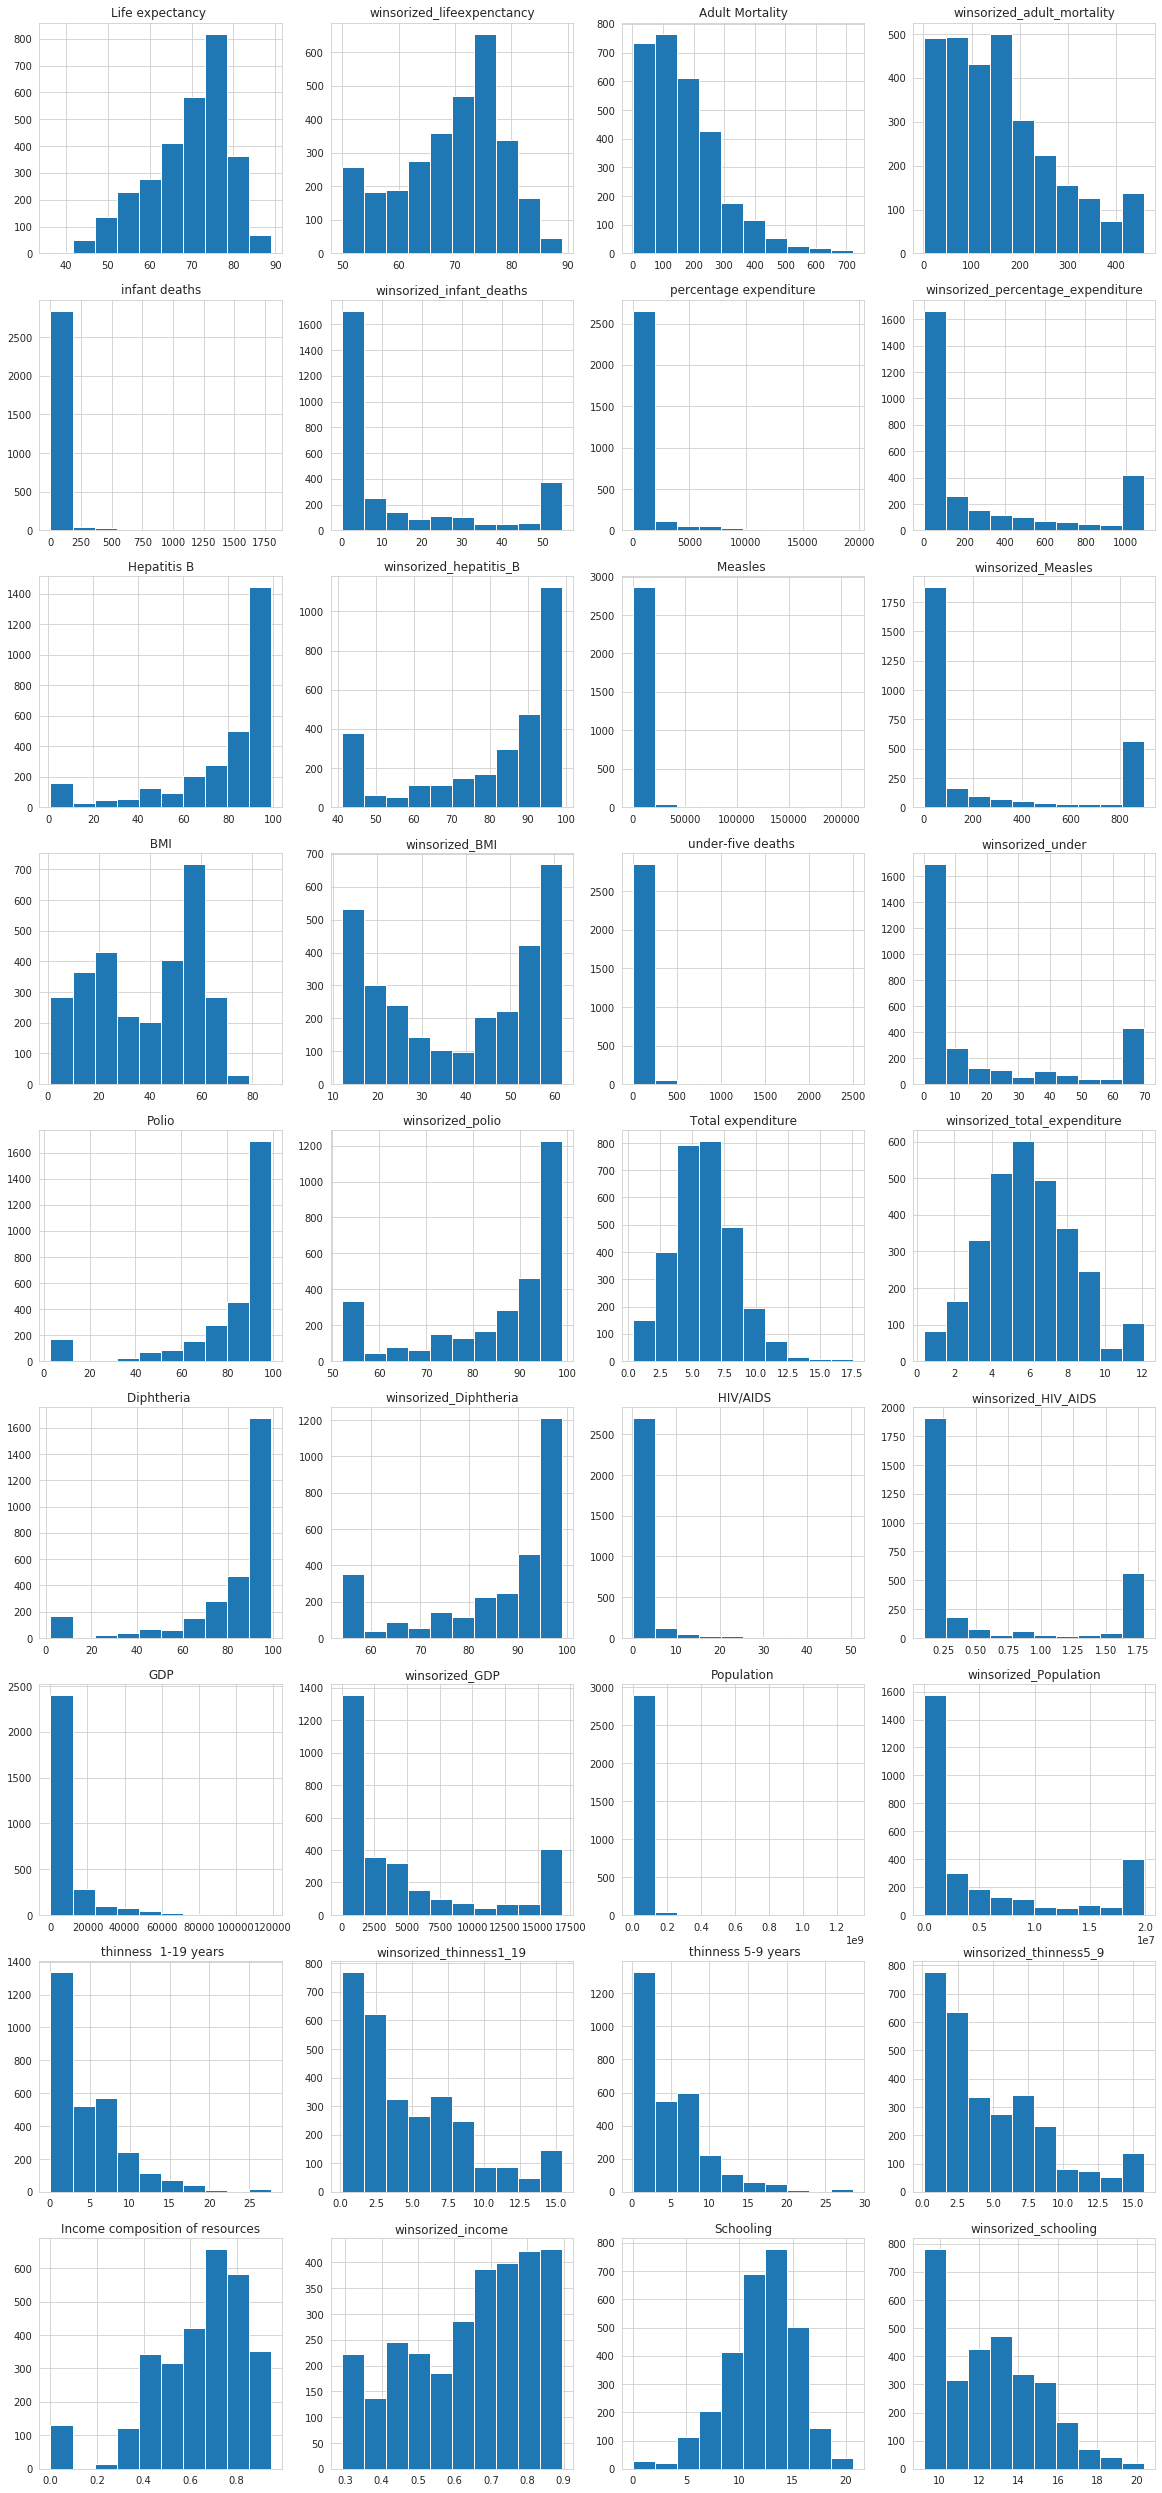

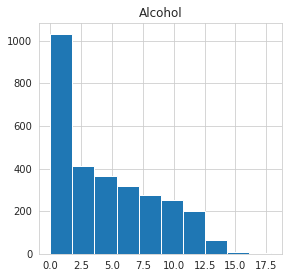

In [0]:
plot_list = [
       'Life expectancy ',  'winsorized_lifeexpenctancy',
       'Adult Mortality','winsorized_adult_mortality',
       'infant deaths', 'winsorized_infant_deaths',
       #'Alcohol', 
       'percentage expenditure', 'winsorized_percentage_expenditure',
       'Hepatitis B','winsorized_hepatitis_B',
       'Measles ',  'winsorized_Measles',
       ' BMI ', 'winsorized_BMI',
       'under-five deaths ', 'winsorized_under',
       'Polio','winsorized_polio', 
       'Total expenditure','winsorized_total_expenditure',
       'Diphtheria ', 'winsorized_Diphtheria',
       ' HIV/AIDS', 'winsorized_HIV_AIDS',
       'GDP', 'winsorized_GDP',
       'Population',   'winsorized_Population',
       ' thinness  1-19 years', 'winsorized_thinness1_19',
       ' thinness 5-9 years', 'winsorized_thinness5_9',
       'Income composition of resources','winsorized_income',  
       'Schooling','winsorized_schooling'
]

plt.figure(figsize=(20,45))

for col_names in plot_list:
    
    plt.subplot(9,4,(plot_list.index(col_names)+1))
    plt.hist(lifeexpectancy[col_names])
    plt.title(col_names)
    
plt.show()



plt.figure(figsize=(20,45))

plt.subplot(9,4,36)
plt.hist(lifeexpectancy['Alcohol'])
plt.title('Alcohol')
plt.show()


We have mostly highly skewed variables. Winsorized lifeexpendancy, winsorized total expenditure and winsorizde schooling looks like a normal distribution.

Univariate visualization of categorical variables
-We have 160 developing and 33 developed countries.Let's look how life expectancy changes through years.

<BarContainer object of 2 artists>

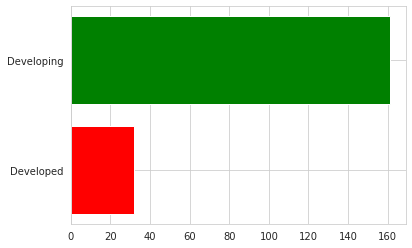

In [0]:
plt.barh( lifeexpectancy["Status"].unique(),
          lifeexpectancy.groupby(["Status"])["Country"].nunique(),
          color = ["red", "green"],
          tick_label = ["Developed", "Developing"]
        )

Text(0, 0.5, 'Life Expectancy')

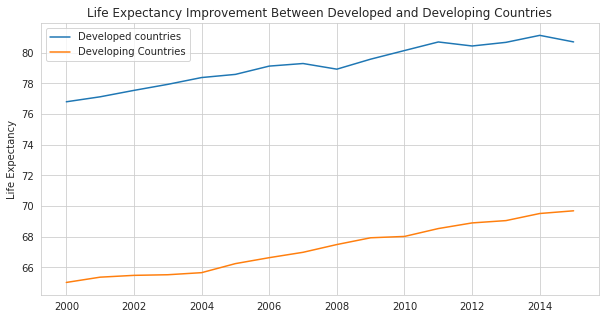

In [0]:
aa = lifeexpectancy[lifeexpectancy["Status"] == "Developed"].groupby(["Year"])['winsorized_lifeexpenctancy'].mean()
ab = lifeexpectancy[lifeexpectancy["Status"] == "Developing"].groupby(["Year"])['winsorized_lifeexpenctancy'].mean()

plt.figure(figsize = (10,5))
plt.plot(aa)
plt.plot(ab)
plt.legend(["Developed countries", "Developing Countries"])
plt.title("Life Expectancy Improvement Between Developed and Developing Countries")
plt.ylabel("Life Expectancy")

In [0]:
import scipy.stats as stats
stats.ttest_ind(lifeexpectancy.loc[lifeexpectancy['Status']=='Developed','Life expectancy '],lifeexpectancy.loc[lifeexpectancy['Status']=='Developing','Life expectancy '])

Ttest_indResult(statistic=29.83135900677773, pvalue=4.960292113465824e-171)

P value shows that there is a significant difference between developed and developing countries. In the following steps, we can use status of the country as a feature. 

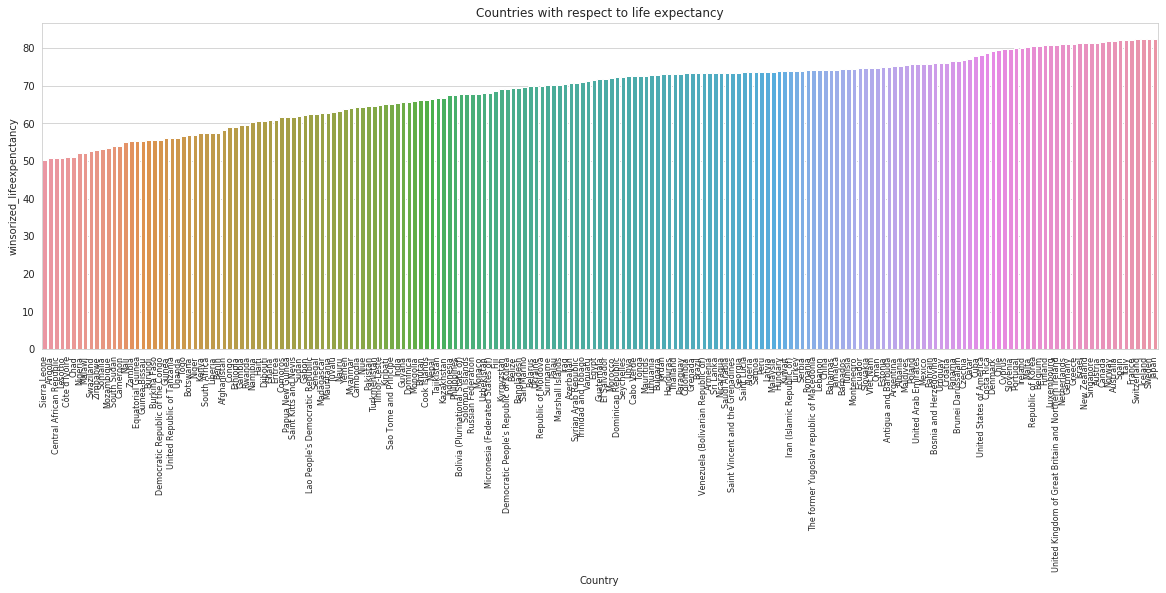

In [0]:
sorted_le = (lifeexpectancy.groupby('Country')['winsorized_lifeexpenctancy'].mean()).sort_values()
plt.figure(figsize=(20,6))
xx = sns.barplot(x = sorted_le.index, y = sorted_le)
xx.set_xticklabels(xx.get_xticklabels(), rotation=90, fontsize=8)
xx.set_title('Countries with respect to life expectancy')
plt.show()



Scatterplots help us to identify a relationship between variables. 
I will draw scatterplots to understand the relationship between life expectancy and other variables.

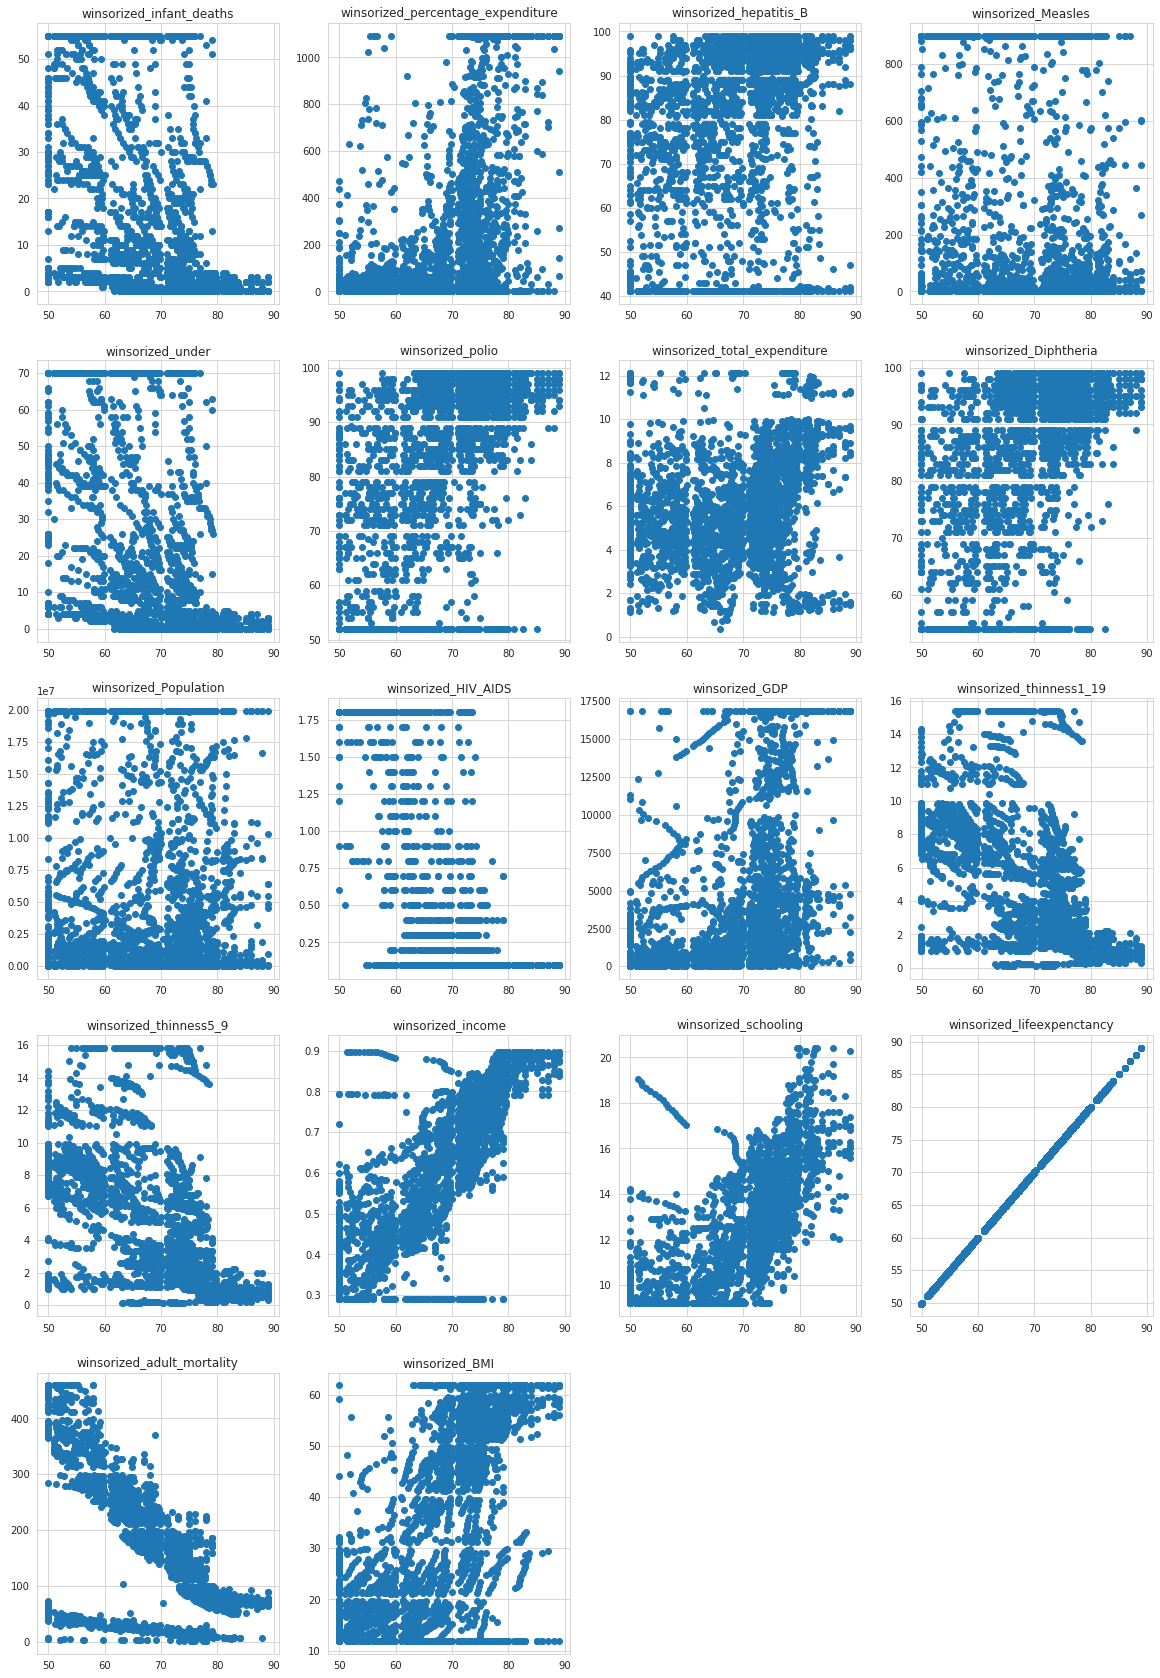

In [0]:
plt.figure(figsize=(20,30))

for col_names in winsorized_lifeexpec.columns:
    
    plt.subplot(5,4,(list(winsorized_lifeexpec.columns).index(col_names)+1))
    plt.scatter(lifeexpectancy['winsorized_lifeexpenctancy'], lifeexpectancy[col_names])
    plt.title(col_names)
    
plt.show()

It looks like there is a positive relationship between life expactency, income and schooling columns.To check our insights and see correlations between other variables, we form correlation matrix and look for the results. If our columns correlation results are closer to 1 or -1 than there is a correlation between them.

Text(0.5, 1, 'correlation matrix (winsorized_lifeexpec)')

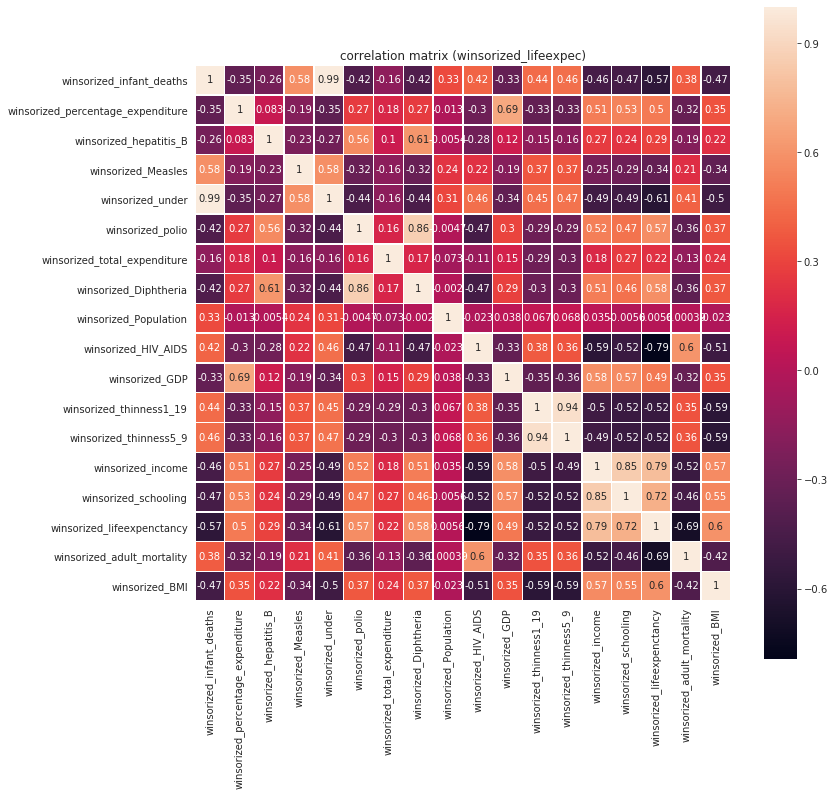

In [0]:
plt.figure(figsize=(12,12))
sns.heatmap(winsorized_lifeexpec.corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (winsorized_lifeexpec)")

* Infant deaths and under 5 deaths are highly correlateed (0,99)
*   Winsorized schooling and winsorized income (0.85) are highly correlateed
*   Winsoriez_thinness1_19 is correlated with winsorized_thinnes5_9.
*   Winsorized_GDP or w.percentage expenditure are correlateed
* Hepatitis B, Dipheria and polio is highley correlated in eachother. PCA can be used to reduce the correlated set of variables into a smaller set of uncorrelated features.We can create a new variable from these 3 variables by using PCA.
* Measles or infant deaths are correlateed.
* BMI is correlated with HIV/AIDS.


# **In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.**

Now, it is time to select our features. Above I discovered that country status may be a benefical feature to use. But it is categorical variable. I need to transform it to use. 

In [0]:
# append dummies to lifeexpectancy dataframe
lifeexpectancy = pd.concat([lifeexpectancy, pd.get_dummies(lifeexpectancy['Status'], drop_first=True)], axis =1)
lifeexpectancy

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,winsorized_infant_deaths,winsorized_percentage_expenditure,winsorized_hepatitis_B,winsorized_Measles,winsorized_under,winsorized_polio,winsorized_total_expenditure,winsorized_Diphtheria,winsorized_Population,winsorized_HIV_AIDS,winsorized_GDP,winsorized_thinness1_19,winsorized_thinness5_9,winsorized_income,winsorized_schooling,winsorized_lifeexpenctancy,winsorized_adult_mortality,winsorized_BMI,Developing
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,55,71.279624,65.000000,899,70,52.0,8.16,65.0,19924522.0,0.1,584.259210,15.4,15.817647,0.479,10.1,65.0,263.0,19.1,1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,55,73.523582,62.000000,492,70,58.0,8.18,62.0,327582.0,0.1,612.696514,15.4,15.817647,0.476,10.0,59.9,271.0,18.6,1
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,55,73.219243,64.000000,430,70,62.0,8.13,64.0,19924522.0,0.1,631.744976,15.4,15.817647,0.470,9.9,59.9,268.0,18.1,1
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,55,78.184215,67.000000,899,70,67.0,8.52,67.0,3696958.0,0.1,669.959000,15.4,15.817647,0.463,9.8,59.5,272.0,17.6,1
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,55,7.097109,68.000000,899,70,68.0,7.87,68.0,2978599.0,0.1,63.537231,15.4,15.817647,0.454,9.5,59.2,275.0,17.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,27.1,42,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2,27,0.000000,68.000000,31,42,67.0,7.13,65.0,12777511.0,1.8,454.366654,9.4,9.400000,0.407,9.2,49.9,459.0,27.1,1
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,26.7,41,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5,26,0.000000,41.035714,899,41,52.0,6.52,68.0,12633897.0,1.8,453.351155,9.8,9.900000,0.418,9.5,49.9,459.0,26.7,1
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,26.3,40,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0,25,0.000000,73.000000,304,40,73.0,6.53,71.0,125525.0,1.8,57.348340,1.2,1.300000,0.427,10.0,49.9,73.0,26.3,1
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,25.9,39,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8,25,0.000000,76.000000,529,39,76.0,6.16,75.0,12366165.0,1.8,548.587312,1.6,1.700000,0.427,9.8,49.9,459.0,25.9,1


In [0]:
#creating a new variable from highly correlated 3 variable by using PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = lifeexpectancy[["winsorized_hepatitis_B", "winsorized_polio",
                  "winsorized_Diphtheria"]]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
lifeexpectancy["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

X_check = lifeexpectancy[["winsorized_hepatitis_B", "winsorized_polio",
                  "winsorized_Diphtheria", "winsorized_lifeexpenctancy", "pca_1"]]
X_check.corr() 

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.78700729]


,winsorized_hepatitis_B,winsorized_polio,winsorized_Diphtheria,winsorized_lifeexpenctancy,pca_1
winsorized_hepatitis_B,1.000000,0.560085,0.607412,0.292677,-0.797077
winsorized_polio,0.560085,1.000000,0.860091,0.573570,-0.920364
winsorized_Diphtheria,0.607412,0.860091,1.000000,0.582281,-0.937348
winsorized_lifeexpenctancy,0.292677,0.573570,0.582281,1.000000,-0.553565
pca_1,-0.797077,-0.920364,-0.937348,-0.553565,1.000000


Above we used correlation matrix to see correlated variables. We can discard the correlated ones. These are the possible feature variables that we dismissed the correlated variables.

In [0]:
lifeexpectancy_possible_features = lifeexpectancy[['winsorized_percentage_expenditure','winsorized_under', 'winsorized_Population', 'winsorized_HIV_AIDS',
'winsorized_lifeexpenctancy','Developing', 'pca_1']]

In [0]:
#machine learning models assume that all features have values in the same range (e.g., a min of 0 and a max of 1) or they exhibit normal statistical 
#properties. For some techniques, features that vary in range can result in incorrect estimates and results. To be able to apply these techniques and 
#methods, we need to rescale our variables to fit a limited range, or standardize our variables to exhibit some regular statistical patterns.

from sklearn.preprocessing import normalize

# normalize the winsorized variables
lifeexpectancy_possible_features["norm_winsorized_percentageexpenditure"] = normalize(np.array(lifeexpectancy_possible_features['winsorized_percentage_expenditure']).reshape(1,-1)).reshape(-1,1)
lifeexpectancy_possible_features["norm_winsorized_under"] = normalize(np.array(lifeexpectancy_possible_features['winsorized_under']).reshape(1,-1)).reshape(-1,1)
lifeexpectancy_possible_features["norm_winsorized_population"] = normalize(np.array(lifeexpectancy_possible_features['winsorized_Population']).reshape(1,-1)).reshape(-1,1)
lifeexpectancy_possible_features["norm_winsorized_HIV_AIDS"] = normalize(np.array(lifeexpectancy_possible_features['winsorized_HIV_AIDS']).reshape(1,-1)).reshape(-1,1)
lifeexpectancy_possible_features["norm_winsorized_lifeexpectancy"] = normalize(np.array(lifeexpectancy_possible_features['winsorized_lifeexpenctancy']).reshape(1,-1)).reshape(-1,1)
lifeexpectancy_possible_features["norm_developing"] = normalize(np.array(lifeexpectancy_possible_features['Developing']).reshape(1,-1)).reshape(-1,1)
lifeexpectancy_possible_features["pca_deseases"] = normalize(np.array(lifeexpectancy_possible_features['pca_1']).reshape(1,-1)).reshape(-1,1)

lifeexpectancy_possible_features = lifeexpectancy_possible_features.iloc[:,7:]

# **Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.**

At the end of data cleaning, data exploration and feature engineering parts I conclude that 5 features can affect the life expectancy. These are:


* percentage expenditure: Expenditure on health as a percentage of Gross Domestic Product per capita(%). High expenditure on health as a % of GDP per capita will increase life expectancy at birth. Because, it will tell us the investment and also the cost of health industry and accesibility to health services.  

* under-five deaths : Number of under-five deaths per 1000 population
Under five deaths decreases life expectancy at birth dramatically. 

* Population: Population of the country. This variable survived every process I applied but it doesn't have a relationship with the life expectancy. Scatter plot shows that there is almost no relationship with life expectancy.I won't select this variable as an effective feature.

* HIV/AIDS: Deaths per 1 000 live births HIV/AIDS (0-4 years)
This variable is like under five deaths. 

* Status: The status of the country developed or developing
Access to countries health services and also proper nutrition is significantly higher in developed countries. 

* pca_deseases : A new feature is created by using hepatitis B, polio and diphteria variables. It has the same explanation with HIV/AIDS and under five deaths.






In [1]:
plt.figure(figsize=(10,6))
sns.scatterplot(lifeexpectancy_possible_features['norm_winsorized_lifeexpectancy'], lifeexpectancy_possible_features['norm_winsorized_population']).set_title('Life expectancy vs Population')


NameError: ignored

Text(0.5, 1, 'correlation matrix (winsorized_lifeexpec)')

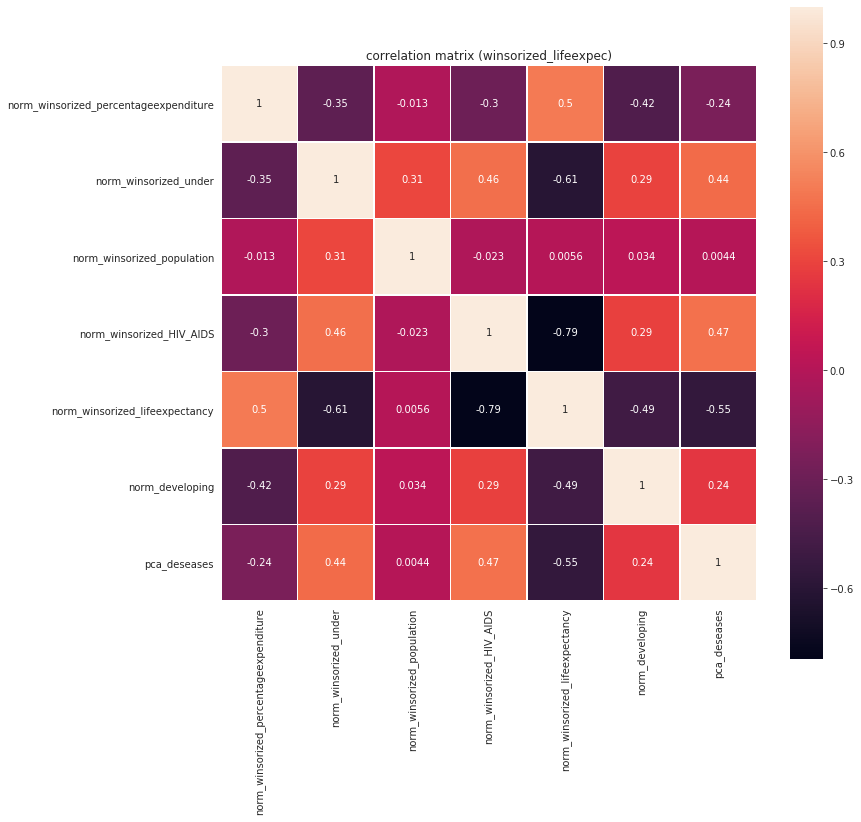

In [0]:
plt.figure(figsize=(12,12))
sns.heatmap(lifeexpectancy_possible_features.corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (winsorized_lifeexpec)")